### Table of Contents
- [Early Exploration](#Early-Exploration)
- [Modules](#module)
- [Vizualization Sections](#Vizualizations)
- [Geographical Exploration](#Geo-Exploration)
- [Modeling Begins](#Modeling)

In [2]:
import pandas as pd
import numpy as np


#visualizations libraries
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('bmh')

#machine learning libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from matplotlib import patheffects

# graphing related libraries
#import pandas_bokeh as gpb
#import geopandas
#from cartopy import crs as ccrs
#import contextily as ctx
#from mpl_toolkits.axes_grid1 import make_axes_locatable



import os


#project modules
import src.wrangle as wr
import src.summaries as su
import src.explore as ex

%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from importlib import reload

In [8]:
plt.style.use('bmh')

In [13]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:128: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week
/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.customer_type.replace({'Assistance Org':'Other'},inplace=True)


## time series at a glance

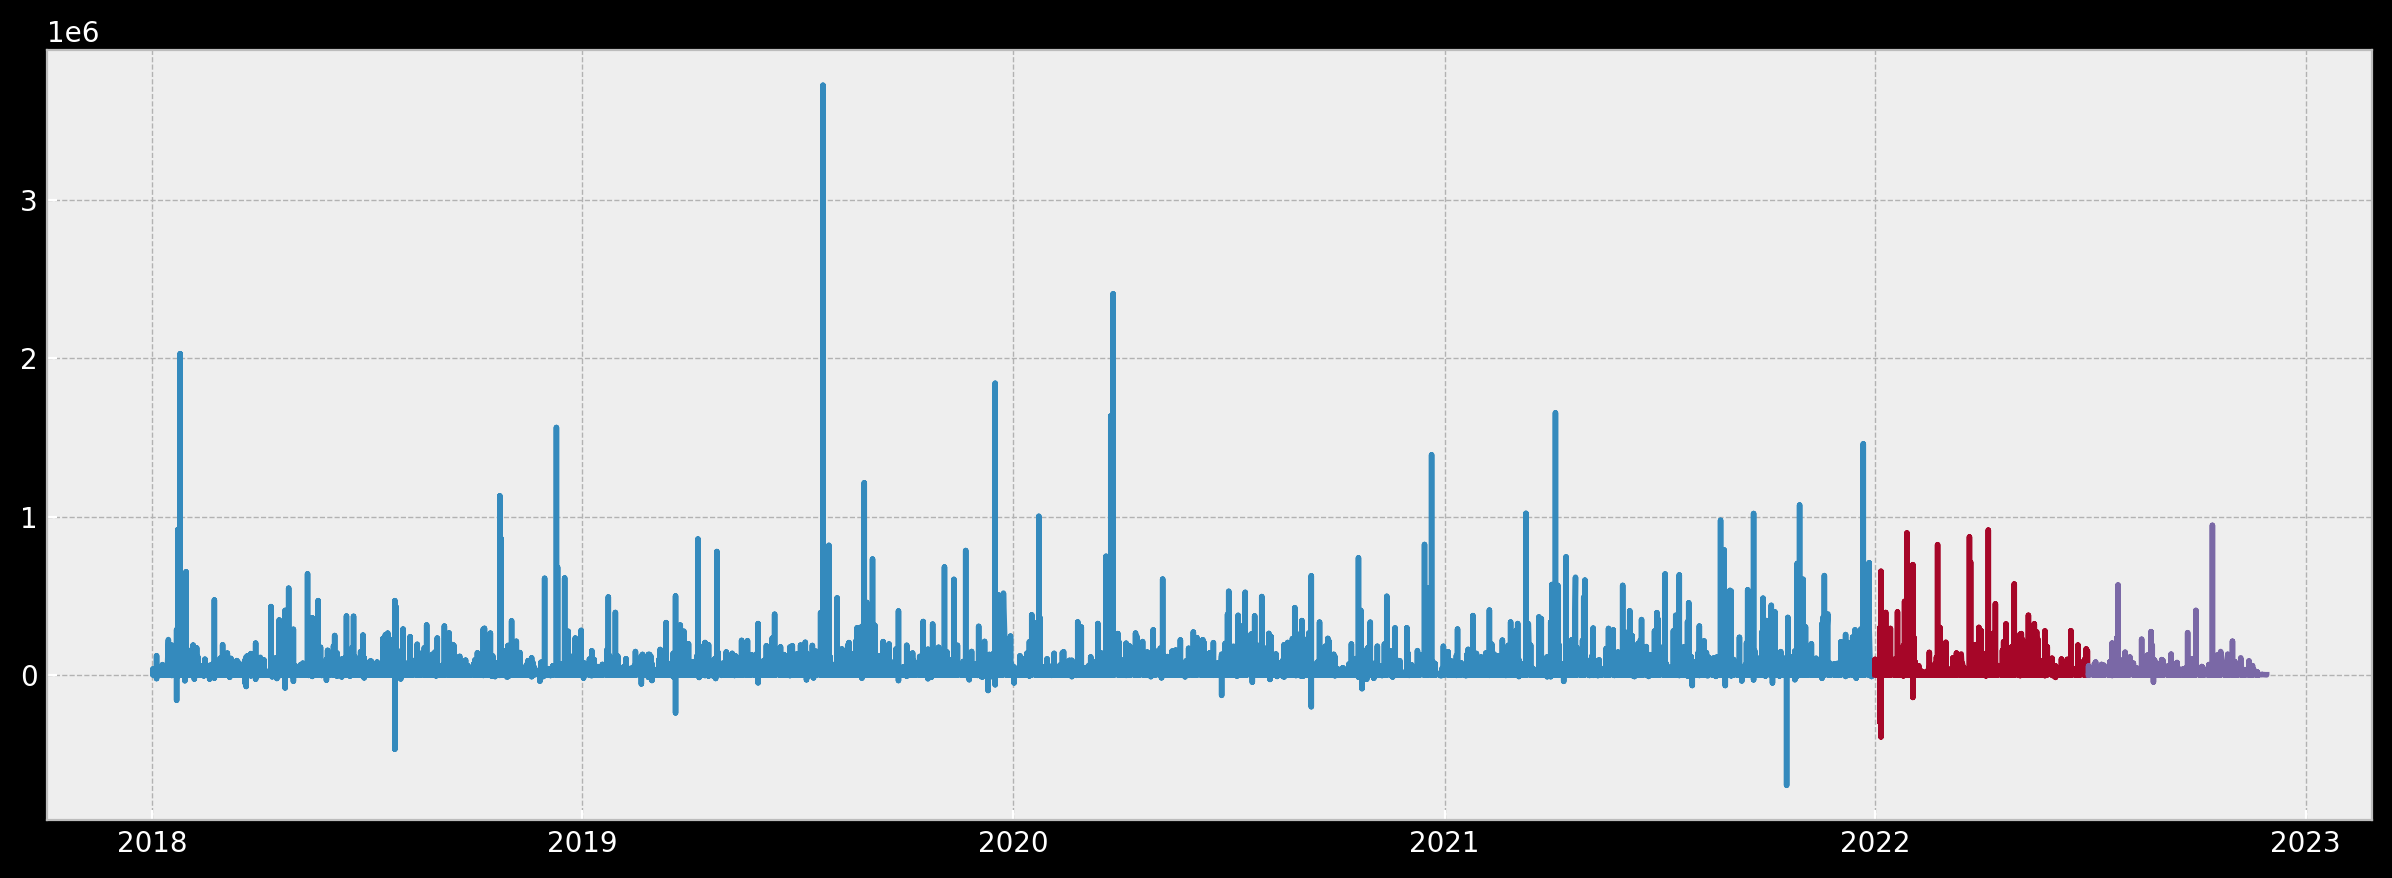

In [14]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(train.index, train['purchase_amount'])
plt.plot(validate.index, validate['purchase_amount'])
plt.plot(test.index, test['purchase_amount'])

### alternative plots

In [15]:
df.head()

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,order_date_copy,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,78370.00000,16.00000,283.25000,173494,2018-01-11,2018-01-02,2018,1,January,Tuesday,1,1,1,2,4532.00000
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,78370.00000,16.00000,178.75000,173494,2018-01-11,2018-01-02,2018,1,January,Tuesday,1,1,1,2,2860.00000
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,78370.00000,16.00000,11.69000,173494,2018-01-11,2018-01-02,2018,1,January,Tuesday,1,1,1,2,187.04000
2018-01-02,Odem-Edroy Independent School District,K-12,Odem,Great South Texas Corporation dba Computer Sol...,San Antonio,78370.00000,16.00000,26.81000,173494,2018-01-11,2018-01-02,2018,1,January,Tuesday,1,1,1,2,428.96000
2018-01-02,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Insight Public Sector, Inc.",Tempe,78586.00000,1.00000,63.36000,191971,2018-02-03,2018-01-02,2018,1,January,Tuesday,1,1,1,2,63.36000


In [19]:
def clean_df(df):
    df = df.drop(columns = ['shipped_date', 'order_date_copy'])
    df['purchase_amount'] = df['purchase_amount'].astype('int64')
    df['customer_zip'] = df['customer_zip'].astype('int16')
    df['order_quantity'] = df['order_quantity'].astype('int16')
    df['unit_price'] = df['unit_price'].astype('float64')
    
    return df

In [20]:
df = clean_df(df)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261886 entries, 2018-01-02 to 2022-11-29
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_name    261886 non-null  object 
 1   customer_type    261886 non-null  object 
 2   customer_city    261886 non-null  object 
 3   reseller_name    261886 non-null  object 
 4   reseller_city    261403 non-null  object 
 5   customer_zip     261886 non-null  int16  
 6   order_quantity   261886 non-null  int16  
 7   unit_price       261886 non-null  float64
 8   po_number        261883 non-null  object 
 9   year             261886 non-null  int64  
 10  quarter          261886 non-null  int64  
 11  month_name       261886 non-null  object 
 12  day_name         261886 non-null  object 
 13  month            261886 non-null  int64  
 14  week             261886 non-null  int64  
 15  day_of_week      261886 non-null  int64  
 16  day_of_year      26188

In [ ]:
df_large_price = df[df['unit_price'] > 5]
df_small_price = df[df['unit_price'] <= 5]

In [ ]:
df_large_price.shape[0], df_small_price.shape[0], df_large_price.shape[0] + df_small_price.shape[0], df.shape[0]

(232629, 29257, 261886, 261886)

In [40]:
df = wr.get_clean_data(start2018=True)
df = clean_df(df)

df_large_price = df[df['unit_price'] > 1]
df_small_price = df[df['unit_price'] <= 1]

lp_train, lp_test = wr.split_data(df_large_price, explore=True)
lp_validate = lp_test.loc[:'2022-06'].copy() 
lp_test = lp_test.loc['2022-07':]

sp_train, sp_test = wr.split_data(df_small_price, explore=True)
sp_validate = sp_test.loc[:'2022-06'].copy() 
sp_test = sp_test.loc['2022-07':]

/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:128: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week
/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.customer_type.replace({'Assistance Org':'Other'},inplace=True)


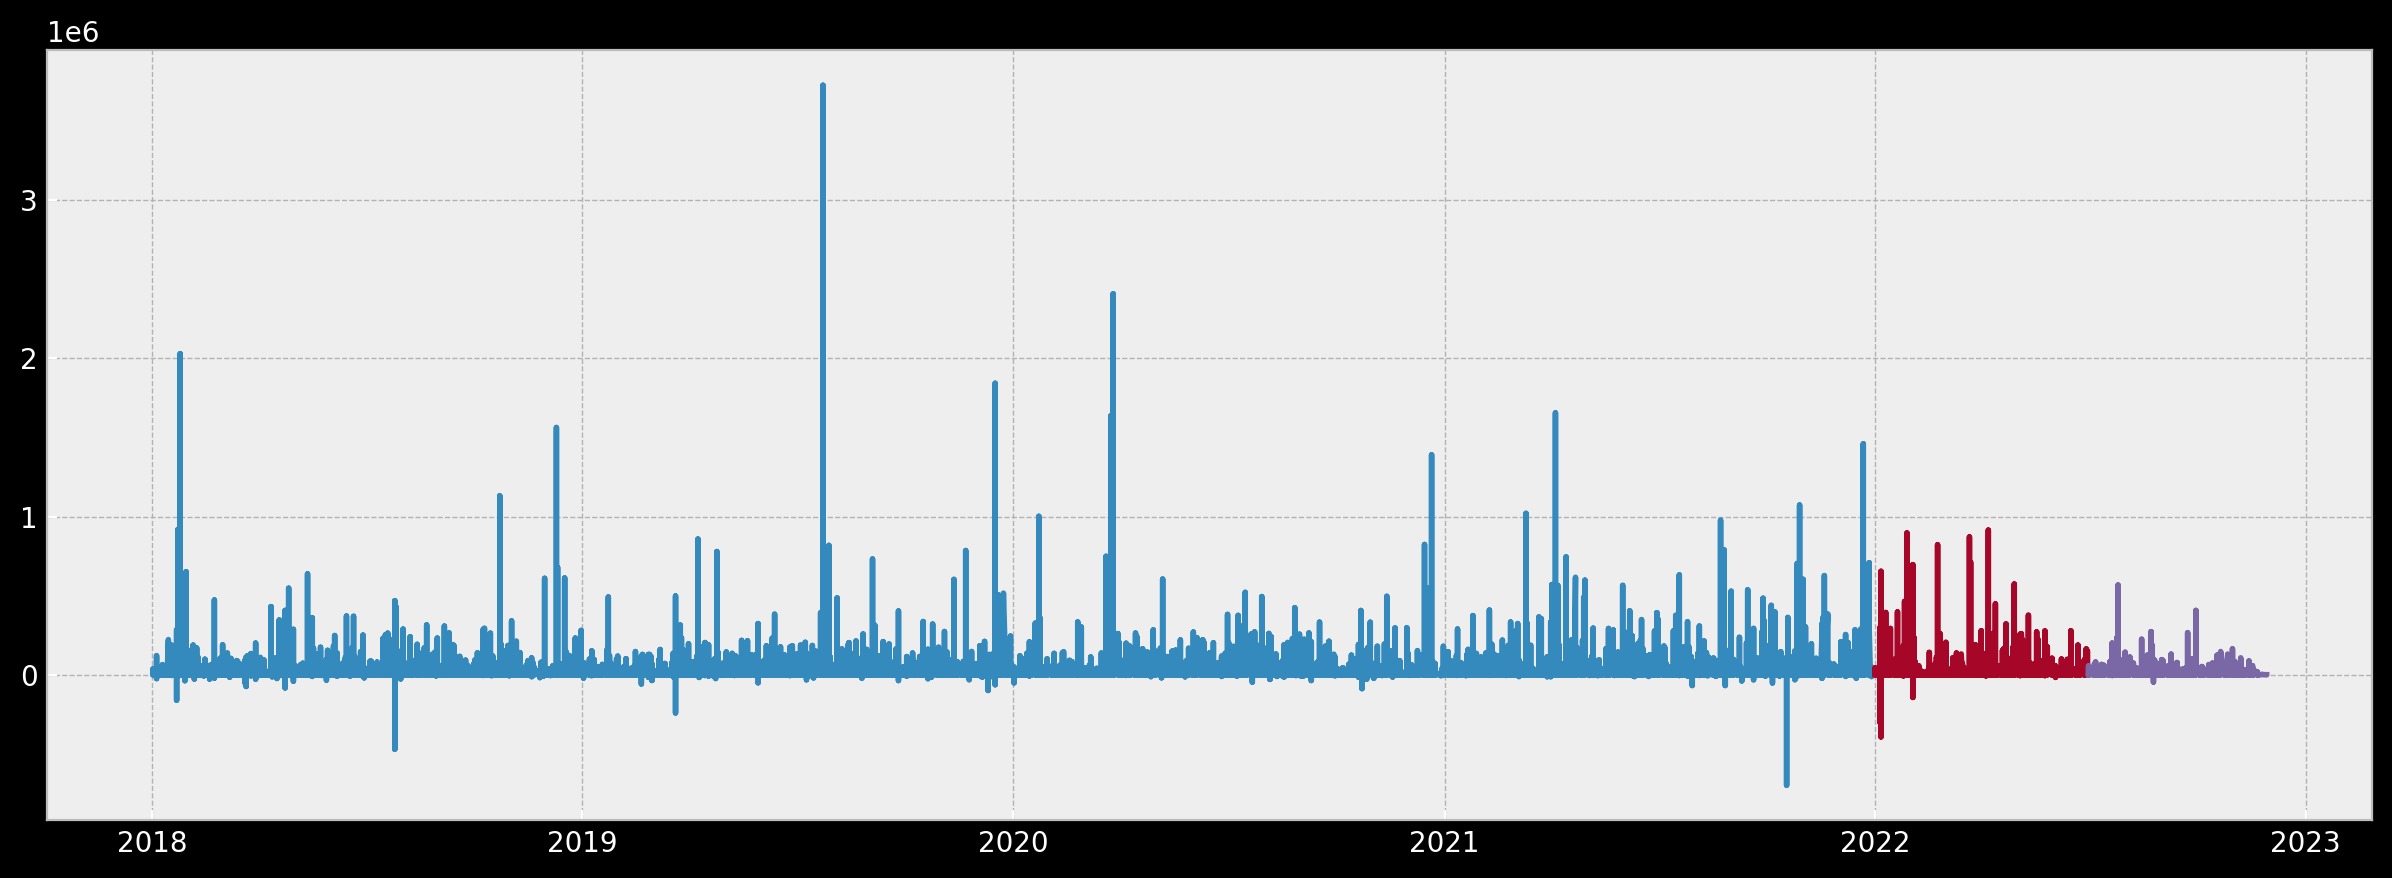

In [ ]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(lp_train.index, lp_train['purchase_amount'])
plt.plot(lp_validate.index, lp_validate['purchase_amount'])
plt.plot(lp_test.index, lp_test['purchase_amount'])

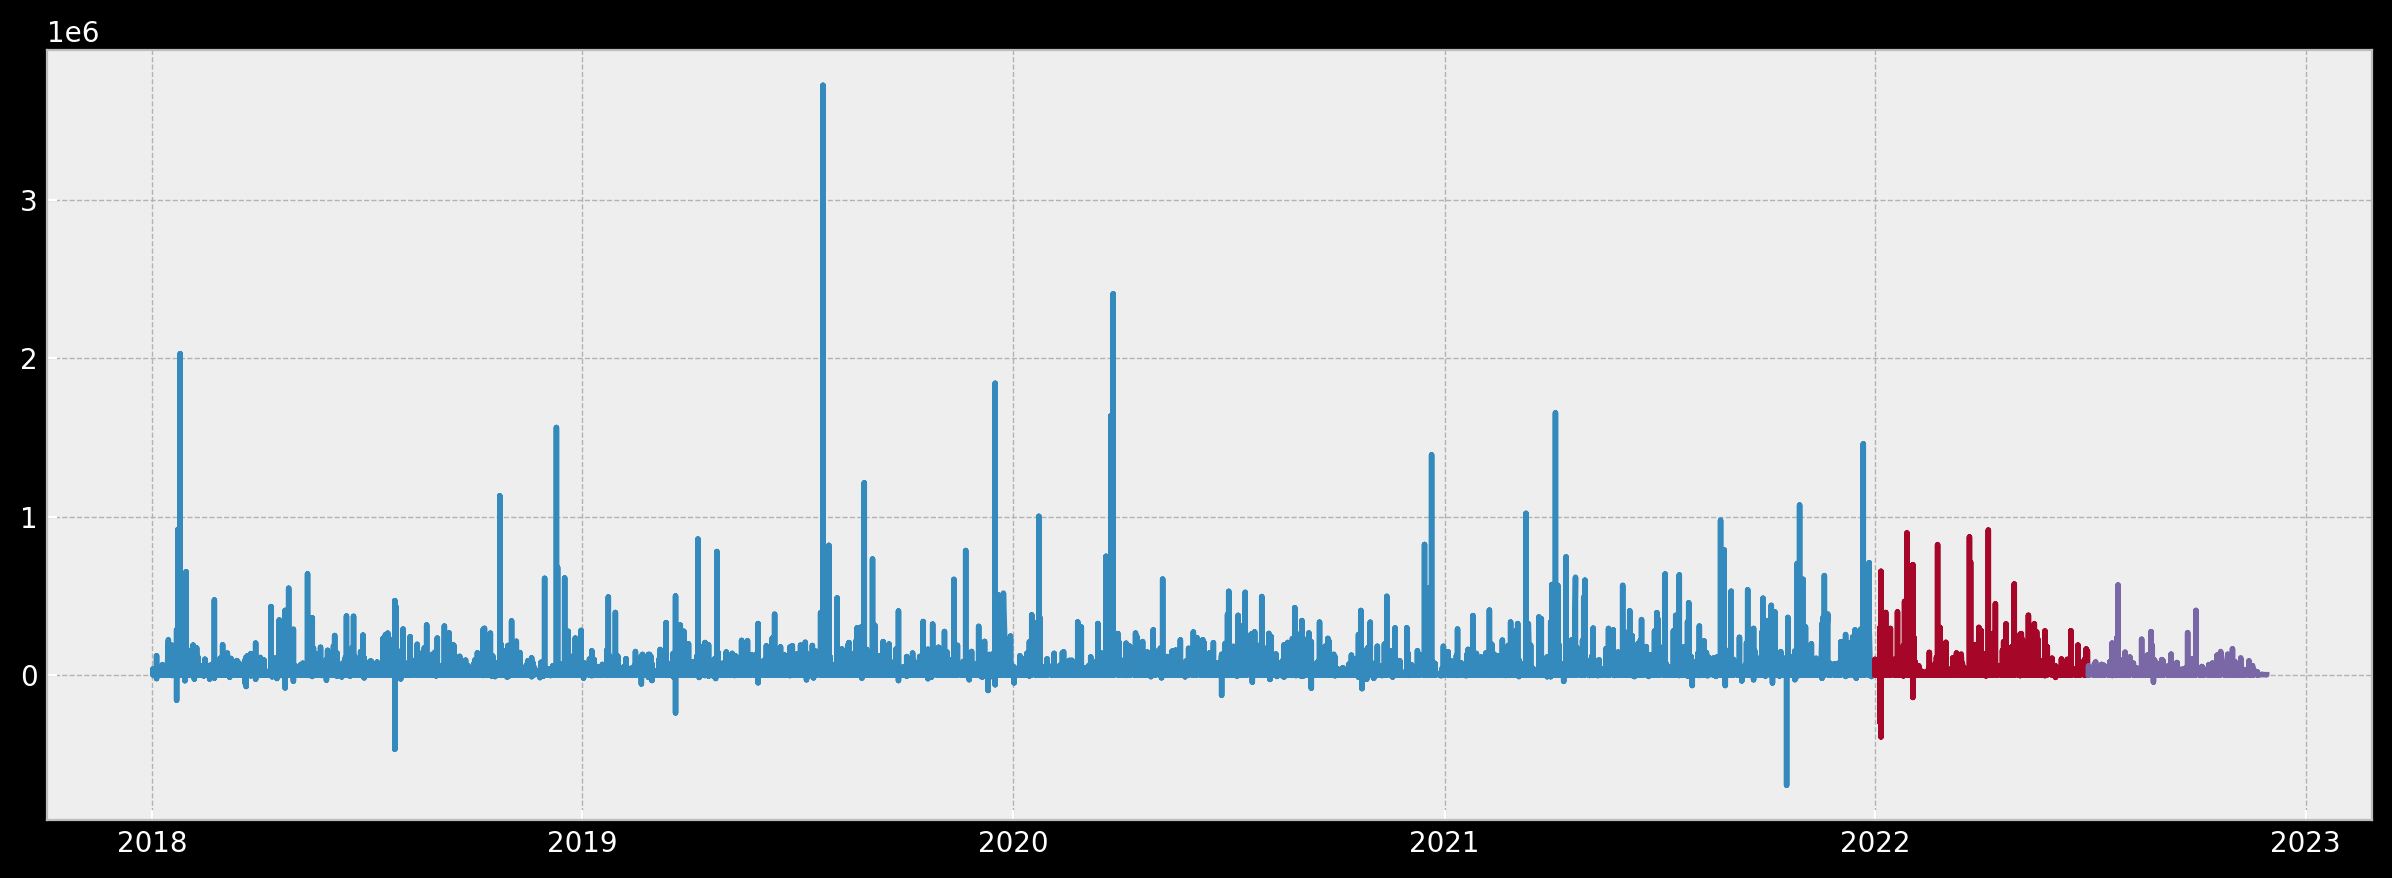

In [41]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(lp_train.index, lp_train['purchase_amount'])
plt.plot(lp_validate.index, lp_validate['purchase_amount'])
plt.plot(lp_test.index, lp_test['purchase_amount'])

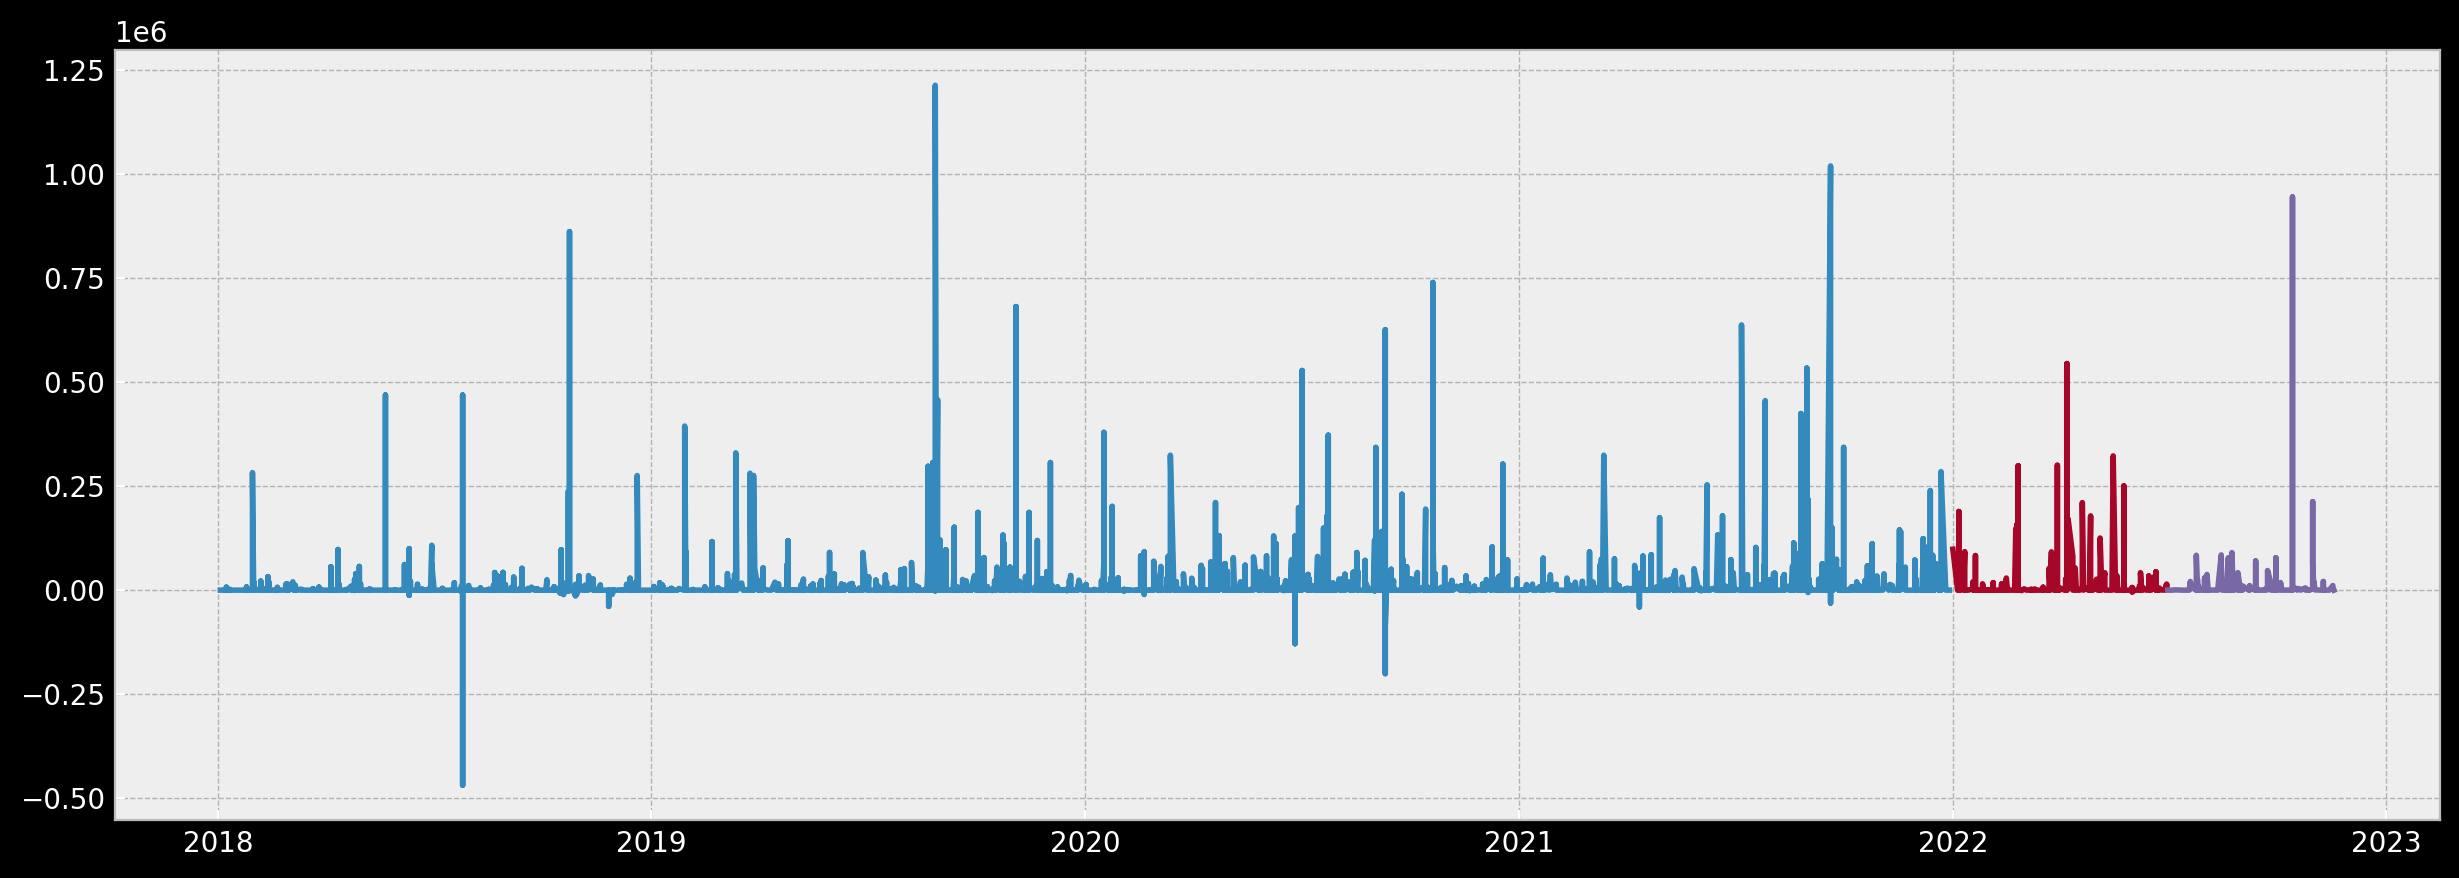

In [ ]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(sp_train.index, sp_train['purchase_amount'])
plt.plot(sp_validate.index, sp_validate['purchase_amount'])
plt.plot(sp_test.index, sp_test['purchase_amount'])

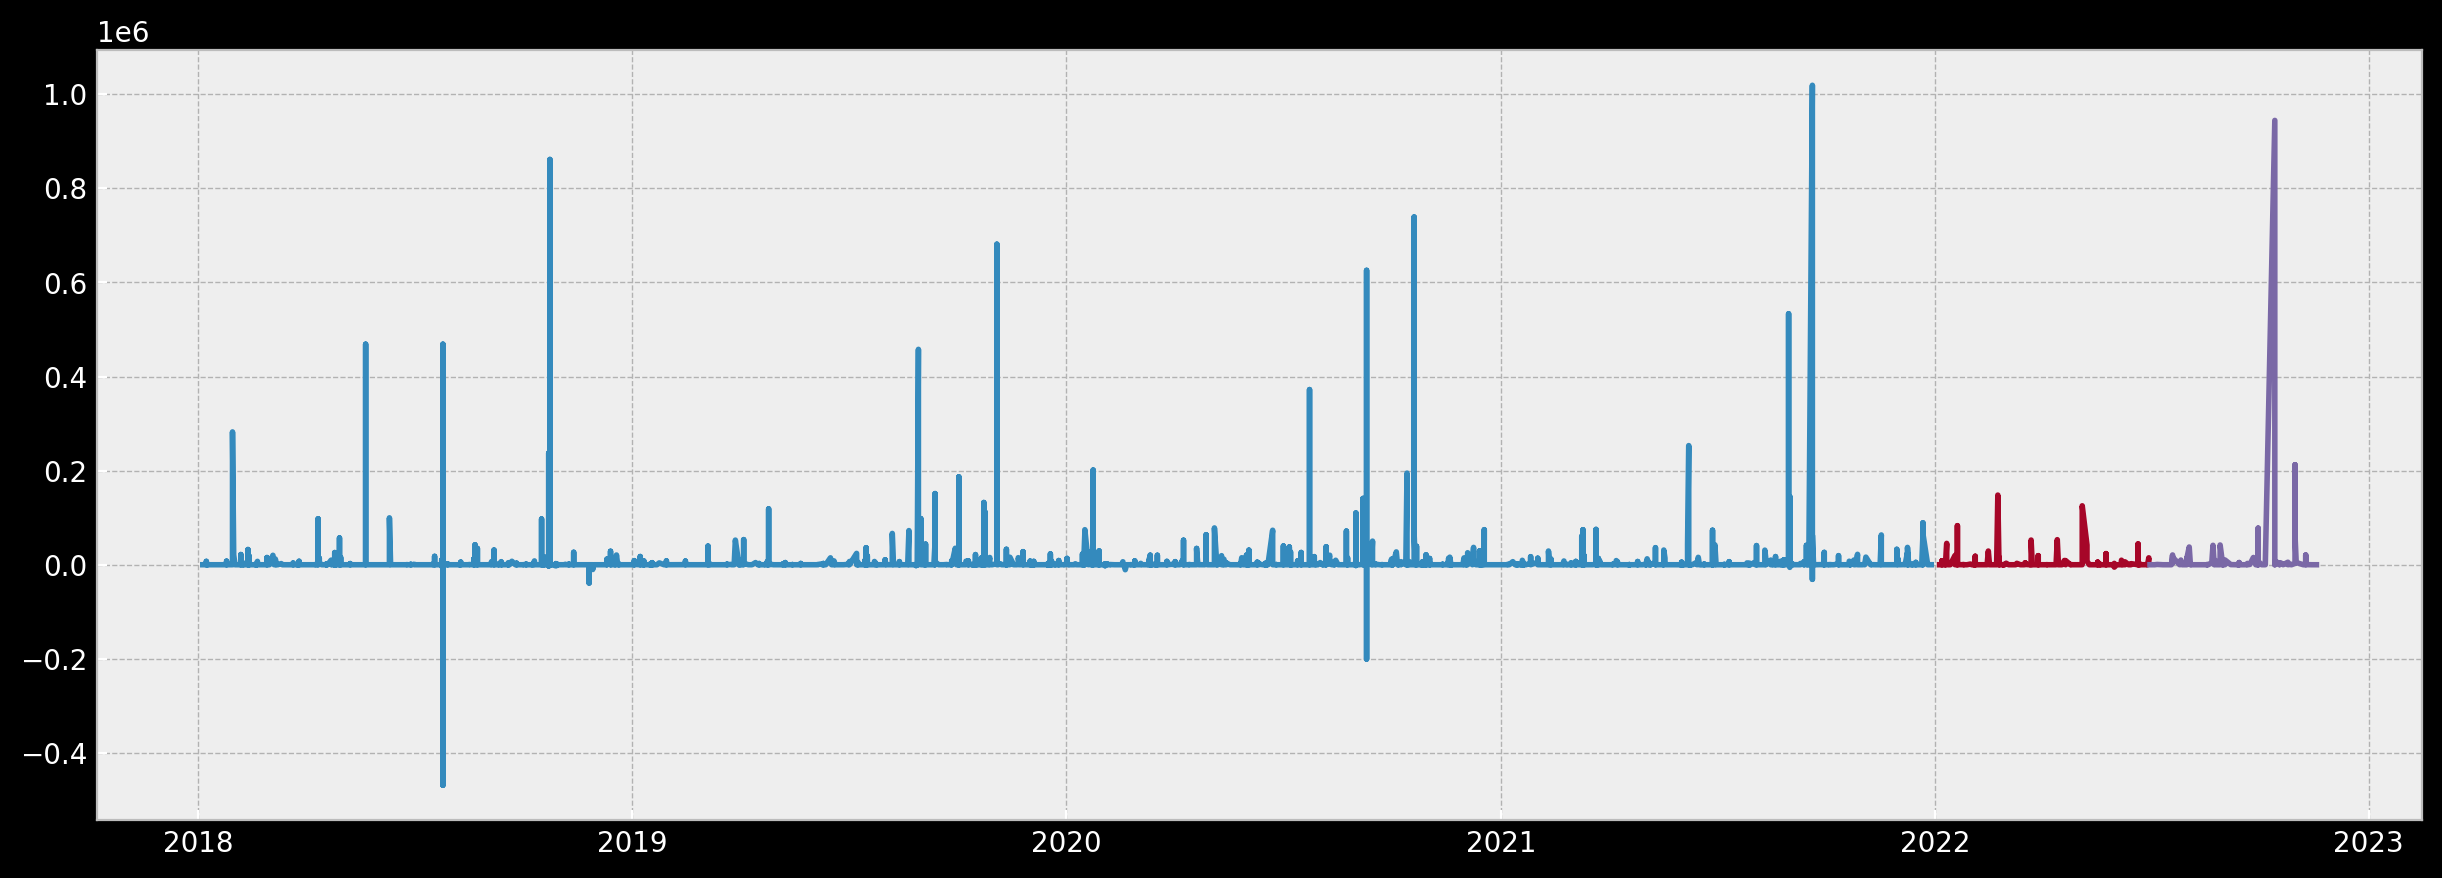

In [42]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(sp_train.index, sp_train['purchase_amount'])
plt.plot(sp_validate.index, sp_validate['purchase_amount'])
plt.plot(sp_test.index, sp_test['purchase_amount'])